In [56]:
import numpy as np
import pandas as pd
import json
import pickle
import os
import numpy as np
import pickle, sys, os
from keras.preprocessing.sequence import pad_sequences
from keras.utils.np_utils import to_categorical
from keras.layers import Embedding
from keras.layers import Dense, Input, Flatten
from keras.layers import TimeDistributed
from keras.layers import LSTM, Bidirectional
from keras.models import Model, load_model
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from sklearn.metrics import accuracy_score, confusion_matrix
import matplotlib.pyplot as plt

In [2]:
lines=[]
for line in open('SemEval2010_task8_all_data/SemEval2010_task8_training/TRAIN_FILE.TXT', 'r'):
    lines.append(line.strip())

In [3]:
data=dict.fromkeys([i for i in range(0,8000)])
k=0
sents=[]
for i in range(0,len(lines),4):
    if lines[i+1]=='Cause-Effect(e2,e1)':
        k+=1
        data[k]={'sent':'', 'type':'', 'comment':''}
        data[k]['sent']=lines[i]
        data[k]['type']=lines[i+1]
        sents.append(lines[i])

In [4]:
sents=[i.split('"')[1] for i in sents]

In [5]:
t=[]
for k in sents:
    k=k[:-1].strip().split()
    l=[]
    for i in k:
        if i[:4] =='<e1>' or i[:-5]=='</e1>':
            l.append((i[4:-5]+'/e'))
        elif i[:4] == '<e2>' or i[:-5]=='</e2>':
            l.append((i[4:-5]+'/c'))
        else:
            l.append((i+'/n'))
    t.append(l)

In [6]:
a=[' '.join(i) for i in t]

In [53]:
with open('semeval-cause-effect.txt', 'w') as f:
    f.write(str(a))

In [4]:
with open('semeval-cause-effect.txt', 'r') as f:
    a=f.read()

In [7]:
sentences=[(' ').join([i[:-2] for i in k.split()]) for k in a]

In [8]:
df_semeval=pd.DataFrame(sentences)

In [9]:
len(sents)

659

In [10]:
#X_train list of split sentences [[akmak,anfa], [afjnadn,jadnfud],....]
#Y_train list of lists of tags for sentences [[c,n,cc,e], [c,e],...]
#words is all words set
#tags is set of all tags
#

In [11]:
X_train = []
Y_train = []

words = []
tags = []

with_slash = False
n_omitted = 0

for line in t:
    if(len(line)>0):
        tempX = []
        tempY = []
        for word in line:
            try:            
                w, tag = word.split('/')
            except:
                # with_slash = True
                n_omitted = n_omitted + 1
                break

            w = w.lower()
            words.append(w)
            tags.append(tag)

            tempX.append(w)
            tempY.append(tag)
        
        X_train.append(tempX)
        Y_train.append(tempY)


print('OMITTED sentences: ', n_omitted, '\n')
print('TOTAL NO OF SAMPLES: ', len(X_train), '\n')


print('sample X_train: ', X_train[42], '\n')
print('sample Y_train: ', Y_train[42], '\n')

words = set(words)
tags = set(tags)

print('VOCAB SIZE: ', len(words))
print('TOTAL TAGS: ', len(tags))

assert len(X_train) == len(Y_train)

OMITTED sentences:  60 

TOTAL NO OF SAMPLES:  658 

sample X_train:  ['relieve', 'spinal', 'stenosis', 'by', 'enlarging', 'the', 'spinal', 'canal', 'to', 'relieve', 'pressure', 'on', 'the', 'spinal', 'cord', 'that', 'has', 'been', 'caused', 'by', 'a', 'herniated', 'or', 'bulging', 'disc'] 

sample Y_train:  ['n', 'n', 'n', 'n', 'n', 'n', 'n', 'n', 'n', 'n', 'e', 'n', 'n', 'n', 'n', 'n', 'n', 'n', 'n', 'n', 'n', 'n', 'n', 'n', 'c'] 

VOCAB SIZE:  4081
TOTAL TAGS:  3


In [12]:
tags

{'c', 'e', 'n'}

In [13]:

word2int = {}
int2word = {}

for i, word in enumerate(words):
    word2int[word] = i+1
    int2word[i+1] = word

tag2int = {}
int2tag = {}

for i, tag in enumerate(tags):
    tag2int[tag] = i+1
    int2tag[i+1] = tag

X_train_numberised = []
Y_train_numberised = []

for sentence in X_train:
    tempX = []
    for word in sentence:
        tempX.append(word2int[word])
    X_train_numberised.append(tempX)

for tagz in Y_train:
    tempY = []
    for tag in tagz:
        tempY.append(tag2int[tag])
    Y_train_numberised.append(tempY)

print('sample X_train_numberised: ', X_train_numberised[42], '\n')
print('sample Y_train_numberised: ', Y_train_numberised[42], '\n')

X_train_numberised = np.asarray(X_train_numberised)
Y_train_numberised = np.asarray(Y_train_numberised)

pickle_files = [X_train_numberised, Y_train_numberised, word2int, int2word, tag2int, int2tag]


sample X_train_numberised:  [729, 2572, 272, 2865, 2659, 3166, 2572, 3481, 3259, 729, 2097, 3897, 3166, 2572, 4, 1103, 3159, 2213, 1021, 2865, 4000, 3266, 283, 1001, 2423] 

sample Y_train_numberised:  [3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 1] 



In [14]:
tags=set(tags)

In [15]:
embeddings_index = {}

with open('glove.6B/glove.6B.100d.txt', encoding="utf8") as glove_file:
    for line in glove_file:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = coefs


In [16]:

# PARAMETERS ================
MAX_SEQUENCE_LENGTH = 100
EMBEDDING_DIM = 100
TEST_SPLIT = 0.1
VALIDATION_SPLIT = 0.1
BATCH_SIZE = 8


In [17]:
X, y, word2int, int2word, tag2int, int2tag = pickle_files 

In [18]:
def generator(all_X, all_y, n_classes, batch_size=BATCH_SIZE):
    num_samples = len(all_X)

    while True:

        for offset in range(0, num_samples, batch_size):
            
            X = all_X[offset:offset+batch_size]
            y = all_y[offset:offset+batch_size]

            y = to_categorical(y, num_classes=n_classes)


            yield shuffle(X, y)


In [19]:
n_tags = len(tag2int)

X = pad_sequences(X, maxlen=MAX_SEQUENCE_LENGTH)
y = pad_sequences(y, maxlen=MAX_SEQUENCE_LENGTH)

# y = to_categorical(y, num_classes=len(tag2int) + 1)

print('TOTAL TAGS', len(tag2int))
print('TOTAL WORDS', len(word2int))


TOTAL TAGS 3
TOTAL WORDS 4081


In [20]:

# shuffle the data
X, y = shuffle(X, y)

# split data into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=TEST_SPLIT,random_state=42)

# split training data into train and validation
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=VALIDATION_SPLIT, random_state=1)

n_train_samples = X_train.shape[0]
n_val_samples = X_val.shape[0]
n_test_samples = X_test.shape[0]
y_test = to_categorical(y_test, num_classes=n_tags+1)

print('We have %d TRAINING samples' % n_train_samples)
print('We have %d VALIDATION samples' % n_val_samples)
print('We have %d TEST samples' % n_test_samples)


We have 532 TRAINING samples
We have 60 VALIDATION samples
We have 66 TEST samples


In [21]:
train_generator = generator(all_X=X_train, all_y=y_train, n_classes=n_tags + 1)
validation_generator = generator(all_X=X_val, all_y=y_val, n_classes=n_tags + 1)



In [42]:
test_generator=generator(all_X=X_test, all_y=y_test, n_classes=n_tags + 1)

In [22]:

print('Total %s word vectors.' % len(embeddings_index))

# + 1 to include the unkown word
embedding_matrix = np.random.random((len(word2int) + 1, EMBEDDING_DIM))

for word, i in word2int.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # words not found in embeddings_index will remain unchanged and thus will be random.
        embedding_matrix[i] = embedding_vector

print('Embedding matrix shape', embedding_matrix.shape)
print('X_train shape', X_train.shape)

Total 400000 word vectors.
Embedding matrix shape (4082, 100)
X_train shape (532, 100)


In [23]:
model=0
embedding_layer = Embedding(len(word2int) + 1,
                            EMBEDDING_DIM,
                            weights=[embedding_matrix],
                            input_length=MAX_SEQUENCE_LENGTH,
                            trainable=True)
sequence_input = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32')
embedded_sequences = embedding_layer(sequence_input)

l_lstm = Bidirectional(LSTM(128, return_sequences=True))(embedded_sequences)
preds = TimeDistributed(Dense(n_tags + 1, activation='softmax'))(l_lstm)
model = Model(sequence_input, preds)


In [24]:

model.compile(loss='categorical_crossentropy',
              optimizer='rmsprop',
              metrics=['acc'])

print("model fitting - Bidirectional LSTM")
model.summary()

model fitting - Bidirectional LSTM
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 100)               0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 100, 100)          408200    
_________________________________________________________________
bidirectional_1 (Bidirection (None, 100, 256)          234496    
_________________________________________________________________
time_distributed_1 (TimeDist (None, 100, 4)            1028      
Total params: 643,724
Trainable params: 643,724
Non-trainable params: 0
_________________________________________________________________


In [25]:

history=model.fit_generator(train_generator, 
                     steps_per_epoch=n_train_samples//BATCH_SIZE,
                     validation_data=validation_generator,
                     validation_steps=n_val_samples//BATCH_SIZE,
                     epochs=25,
                     verbose=1,
                     workers=1)
# fit_generator(generator, steps_per_epoch=None, epochs=1, verbose=1, callbacks=None, 
#               validation_data=None, validation_steps=None, validation_freq=1, class_weight=None, 
#               max_queue_size=10, workers=1, use_multiprocessing=False, shuffle=True, initial_epoch=0)


Epoch 1/25
66/66 [==============================] - 15s 226ms/step - loss: 0.1005 - acc: 0.9625 - val_loss: 0.0526 - val_acc: 0.9793
Epoch 2/25
66/66 [==============================] - 13s 193ms/step - loss: 0.0390 - acc: 0.9849 - val_loss: 0.0342 - val_acc: 0.9875
Epoch 3/25
66/66 [==============================] - 13s 197ms/step - loss: 0.0256 - acc: 0.9903 - val_loss: 0.0277 - val_acc: 0.9898
Epoch 4/25
66/66 [==============================] - 14s 206ms/step - loss: 0.0196 - acc: 0.9927 - val_loss: 0.0250 - val_acc: 0.9904
Epoch 5/25
66/66 [==============================] - 14s 205ms/step - loss: 0.0148 - acc: 0.9945 - val_loss: 0.0248 - val_acc: 0.9908
Epoch 6/25
66/66 [==============================] - 14s 205ms/step - loss: 0.0111 - acc: 0.9963 - val_loss: 0.0291 - val_acc: 0.9892
Epoch 7/25
66/66 [==============================] - 14s 219ms/step - loss: 0.0080 - acc: 0.9973 - val_loss: 0.0271 - val_acc: 0.9904
Epoch 8/25
66/66 [==============================] - 15s 222ms/step - 

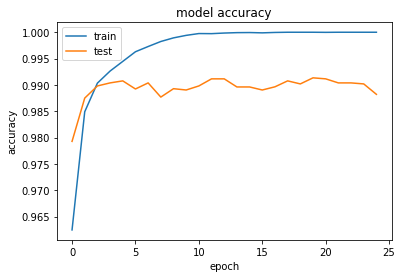

In [28]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()


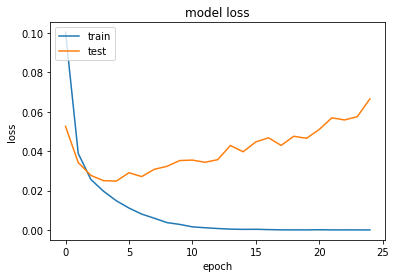

In [30]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [31]:
if not os.path.exists('Models/'):
    print('MAKING DIRECTORY Models/ to save model file')
    os.makedirs('Models/')

train = True

if train:
    model.save('Models/model_semeval_v1.h5')
    print('MODEL SAVED in Models/ as model.h5')
else:
    from keras.models import load_model
    model = load_model('Models/model_0622_v4.h5')

# y_test = to_categorical(y_test, num_classes=n_tags+1)
test_results = model.evaluate(X_test, y_test, verbose=1)
print('TEST LOSS %f \nTEST ACCURACY: %f' % (test_results[0], test_results[1]))


MODEL SAVED in Models/ as model.h5
66/66 [==============================] - 0s 3ms/step
TEST LOSS 0.055588 
TEST ACCURACY: 0.990606


In [67]:
pred_df_sub.word.value_counts()

inflammation       2
earthquake         2
pendulum           1
case               1
stress             1
usgs               1
dust<              1
smiling            1
command            1
sources            1
coal               1
longings           1
war                1
condemning         1
larynx             1
cancers<           1
repetition         1
contraction        1
drumming           1
running            1
irritants          1
parasite           1
elbow              1
fireworks<         1
tenenbaums)        1
mania<             1
cockroaches<       1
cavity             1
initiated          1
indigestion        1
tension            1
resources          1
deprivation        1
globalization      1
pleads             1
pleas              1
exhaustion         1
shape              1
funding            1
virus<             1
poverty            1
compliance         1
preservation       1
cancer             1
arm                1
induced            1
ulceration         1
shaking      

In [39]:
X_test[2]

array([   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0, 3166, 2992, 1444, 2305, 3458, 1103, 3166, 4048,   80, 1983,
       3166, 3327, 2626,  298, 2937, 1955, 1103, 1042, 3166, 1560, 2699,
       3765], dtype=int32)

In [34]:
xtest=[[int2word[i] for i in j if i!=0] for j in X_test]

In [37]:
' '.join(xtest[2])

'the world health organization(who) found that the radiation release from the chernobyl accident was 200 times that of the hiroshima and nagasaki'

In [38]:
[int2tag[j] for j in [np.where(i==1)[0][0] for i in y_test[2]] if j !=0]

['n',
 'n',
 'n',
 'n',
 'n',
 'n',
 'n',
 'e',
 'n',
 'n',
 'n',
 'n',
 'c',
 'n',
 'n',
 'n',
 'n',
 'n',
 'n',
 'n',
 'n',
 'n']

In [48]:
model.predict(X_test)[2].argmax(1)

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 3, 3, 3, 3, 3, 3, 2, 3, 3, 3, 3, 1, 3,
       3, 3, 3, 3, 3, 3, 3, 3])

In [96]:
model2=0
embedding_layer2 = Embedding(len(word2int) + 1,
                            EMBEDDING_DIM,
                            weights=[embedding_matrix],
                            input_length=MAX_SEQUENCE_LENGTH,
                            trainable=True)
sequence_input2 = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32')
embedded_sequences2 = embedding_layer(sequence_input2)

l_lstm2 = LSTM(128, return_sequences=True)(embedded_sequences2)
l_lstm22 = LSTM(128, return_sequences=True)(l_lstm2)
preds2 = TimeDistributed(Dense(n_tags + 1, activation='softmax'))(l_lstm22)
model2 = Model(sequence_input2, preds2)

In [97]:

model2.compile(loss='categorical_crossentropy',
              optimizer='rmsprop',
              metrics=['acc'])

print("model fitting - LSTM")
model2.summary()

model fitting - LSTM
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 100)               0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 100, 100)          408200    
_________________________________________________________________
lstm_3 (LSTM)                (None, 100, 128)          117248    
_________________________________________________________________
lstm_4 (LSTM)                (None, 100, 128)          131584    
_________________________________________________________________
time_distributed_3 (TimeDist (None, 100, 4)            516       
Total params: 657,548
Trainable params: 657,548
Non-trainable params: 0
_________________________________________________________________


In [98]:

model2.fit_generator(train_generator, 
                     steps_per_epoch=n_train_samples//BATCH_SIZE,
                     validation_data=validation_generator,
                     validation_steps=n_val_samples//BATCH_SIZE,
                     epochs=10,
                     verbose=1,
                     workers=1)

Epoch 1/10
66/66 [==============================] - 36s 539ms/step - loss: 0.1360 - acc: 0.9581 - val_loss: 0.0580 - val_acc: 0.9798
Epoch 2/10
66/66 [==============================] - 26s 391ms/step - loss: 0.0295 - acc: 0.9896 - val_loss: 0.0391 - val_acc: 0.9865
Epoch 3/10
66/66 [==============================] - 26s 400ms/step - loss: 0.0129 - acc: 0.9958 - val_loss: 0.0391 - val_acc: 0.9850
Epoch 4/10
66/66 [==============================] - 27s 409ms/step - loss: 0.0084 - acc: 0.9972 - val_loss: 0.0382 - val_acc: 0.9883
Epoch 5/10
66/66 [==============================] - 28s 417ms/step - loss: 0.0056 - acc: 0.9983 - val_loss: 0.0434 - val_acc: 0.9877
Epoch 6/10
66/66 [==============================] - 27s 416ms/step - loss: 0.0038 - acc: 0.9988 - val_loss: 0.0539 - val_acc: 0.9860
Epoch 7/10
66/66 [==============================] - 26s 399ms/step - loss: 0.0032 - acc: 0.9990 - val_loss: 0.0524 - val_acc: 0.9875
Epoch 8/10
66/66 [==============================] - 28s 426ms/step - 

In [99]:
if not os.path.exists('Models/'):
    print('MAKING DIRECTORY Models/ to save model file')
    os.makedirs('Models/')

train = True

if train:
    model.save('Models/model_semeval_lstm_v2.h5')
    print('MODEL SAVED in Models/ as model.h5')
else:
    from keras.models import load_model
    model = load_model('Models/model_semeval_lstm_v2.h5')

# y_test = to_categorical(y_test, num_classes=n_tags+1)
test_results = model.evaluate(X_test, y_test, verbose=1)
print('TEST LOSS %f \nTEST ACCURACY: %f' % (test_results[0], test_results[1]))

MODEL SAVED in Models/ as model.h5
66/66 [==============================] - 0s 3ms/step
TEST LOSS 0.058038 
TEST ACCURACY: 0.990758


In [50]:
y_test[0].argmax(1)

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 2, 3, 1])

In [51]:
y_pred=model.predict(X_test, verbose=1)
yp=[y.argmax(1) for y in y_pred]
yt=[t.argmax(1) for t in y_test]
ytt=[m for n in [[int2tag[j] for j in k if j !=0] for k in yt] for m in n]
ypp=[m for n in [[int2tag[j] for j in k if j !=0] for k in yp] for m in n]

66/66 [==============================] - 1s 15ms/step


In [53]:
Xtt=[m for n in [[int2word[j] for j in k if j not in [0]] for k in X_test] for m in n]

In [54]:
pred_df=pd.DataFrame(list(zip(Xtt, ytt, ypp)))
pred_df.columns=['word', 'true', 'pred']
pred_df_sub=pred_df[pred_df['true']!=pred_df['pred']]

In [66]:
confusion_matrix(pred_df['true'], pred_df['pred'], labels=['e', 'c', 'n'])

array([[  52,    0,   14],
       [   1,   46,   19],
       [  12,   16, 1125]])

In [52]:
accuracy_score(ytt, ypp)#bi-lstm

0.95175097276264586

In [95]:
accuracy_score(ytt, ypp)#lstm

0.9319838056680162

In [101]:
accuracy_score(ytt, ypp)#lstm 2

0.92550607287449393

In [64]:
len(ytt)

1285

In [65]:
ytt

['n',
 'n',
 'n',
 'n',
 'n',
 'n',
 'n',
 'n',
 'n',
 'n',
 'n',
 'n',
 'n',
 'e',
 'n',
 'c',
 'n',
 'n',
 'n',
 'n',
 'n',
 'n',
 'n',
 'n',
 'n',
 'n',
 'n',
 'n',
 'n',
 'n',
 'n',
 'n',
 'n',
 'n',
 'n',
 'n',
 'n',
 'n',
 'n',
 'n',
 'n',
 'n',
 'n',
 'n',
 'n',
 'n',
 'n',
 'e',
 'n',
 'n',
 'n',
 'n',
 'n',
 'n',
 'c',
 'n',
 'n',
 'n',
 'n',
 'n',
 'n',
 'n',
 'e',
 'n',
 'n',
 'n',
 'n',
 'c',
 'n',
 'n',
 'n',
 'n',
 'n',
 'n',
 'n',
 'n',
 'n',
 'n',
 'n',
 'n',
 'n',
 'e',
 'n',
 'n',
 'n',
 'n',
 'n',
 'n',
 'n',
 'c',
 'n',
 'n',
 'n',
 'n',
 'n',
 'n',
 'n',
 'n',
 'e',
 'n',
 'n',
 'n',
 'c',
 'n',
 'n',
 'n',
 'n',
 'n',
 'n',
 'n',
 'n',
 'n',
 'n',
 'n',
 'n',
 'n',
 'e',
 'n',
 'n',
 'n',
 'n',
 'c',
 'n',
 'n',
 'n',
 'e',
 'n',
 'n',
 'n',
 'n',
 'n',
 'n',
 'c',
 'n',
 'n',
 'n',
 'n',
 'n',
 'n',
 'n',
 'n',
 'n',
 'n',
 'n',
 'n',
 'e',
 'n',
 'n',
 'n',
 'c',
 'n',
 'n',
 'n',
 'n',
 'n',
 'n',
 'n',
 'n',
 'n',
 'n',
 'n',
 'n',
 'n',
 'n',
 'n',
 'n',
 'n'

In [71]:
a=['']

In [72]:
if a:
    print('o')

o
